# Testing the Forrest

## Importing the Basics

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from machineLearning.metric import ConfusionMatrix, RegressionScores
from machineLearning.utility import ModelIO
from machineLearning.data import DataSet
from machineLearning.rf import (
    RandomForest, DecisionTree,
    Gini, Entropy, MAE, MSE, ODD,
    Mode, Mean, Confidence, Probabilities, AnomalyDetection,
    CART, ID3, C45, RSA,
    AdaBoosting, GradientBoosting,
    Majority, Confidence, Average, Median
)

## Generating Test Data

Here I generate random test data. It's two blocks shifted very slightly in some dimensions. For classifier tasks each block gets a label, for regressor tasks each block gets the average coordinates plus some random value as a traget. It's a very simple dummy data set meant for testing the code.

Here one can change the dimensionallity and amount of the data.

In [2]:
def dataShift(dims):
    offSet = [5, 1.5, 2.5]
    diffLen = abs(len(offSet) - dims)
    offSet.extend([0] * diffLen)
    random.shuffle(offSet)
    return offSet[:dims]

# Initialize some parameters
totalAmount = 64000
dims = 7
evalAmount = totalAmount // 4
trainAmount = totalAmount - evalAmount
offSet = dataShift(dims)

# Create covariance matrix
cov = np.eye(dims)  # This creates a covariance matrix with variances 1 and covariances 0

# Generate random multivariate data
oneData = np.random.multivariate_normal(np.zeros(dims), cov, totalAmount)
twoData = np.random.multivariate_normal(offSet, cov, totalAmount)

# Split the data into training and evaluation sets
trainData = np.vstack((oneData[:trainAmount], twoData[:trainAmount]))
validData = np.vstack((oneData[trainAmount:], twoData[trainAmount:]))

# Labels for classification tasks
trainLabels = np.hstack((np.zeros(trainAmount), np.ones(trainAmount)))
validLabels = np.hstack((np.zeros(evalAmount), np.ones(evalAmount)))

# Targets for regression tasks
trainTargets = np.sum(trainData, axis=1) + np.random.normal(0, 0.1, 2*trainAmount)
validTargets = np.sum(validData, axis=1) + np.random.normal(0, 0.1, 2*evalAmount)

# Shuffle the training data
trainIndex = np.random.permutation(len(trainData))
trainData = trainData[trainIndex]
trainLabels = trainLabels[trainIndex]
trainTargets = trainTargets[trainIndex]

## Creating the Forrest

Here the forrest is created. One can set the number of trees and set the maximum depth. Depending on the task, we add a different impurity function and a different leaf function. Finally we add the split algorithm and set the feature percentile. Higher numbers look at more possible splits, but decreases speed. Lower numbers look at less possible splits, speeding up the algorithm. Depending on the data set this can have a strong impact on the performance.

One can set a different depth, leaf function, splitting algorithm and impurity function for each tree. Here in this simple case we create all trees with same parameters.

In [3]:
task = 'classifier' # 'classifier'/'regressor'/'outlier'
forrest = RandomForest(retrainFirst=False)
#forrest.setComponent(AdaBoosting()) # GradientBoosting() / AdaBoosting()
forrest.setComponent(Majority())
for i in range(5):
    tree = DecisionTree(maxDepth=7, minSamplesSplit=2)
    if task == 'regressor':
        tree.setComponent(MSE())
        tree.setComponent(Mean())
        tree.setComponent(CART(featurePercentile=90))
    elif task == 'classifier':
        tree.setComponent(Entropy())
        tree.setComponent(Mode())
        tree.setComponent(CART(featurePercentile=90))
    elif task == 'outlier':
        tree.setComponent(RSA())
        tree.setComponent(ODD())
        tree.setComponent(AnomalyDetection())
    forrest.append(tree)


if task == 'classifier':
    trainSet = DataSet(trainData, labels=trainLabels, targets=trainLabels)
    validSet = DataSet(validData, labels=validLabels, targets=validLabels)
elif task == 'regressor':
    trainSet = DataSet(trainData, labels=trainTargets, targets=trainTargets)
    validSet = DataSet(validData, labels=validTargets, targets=validTargets)
else:
    trainSet = DataSet(trainData)
    validSet = DataSet(validData)

## Trainining the tree

Again, depending on the task we train the forrest with targets or labels. Then we make a prediction and plot the tree.

In [4]:
forrest.train(trainSet)
forrest.bake()
prediction = forrest.eval(validSet)
print(forrest)

tree 1 |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔                  | 40%
tree 2 |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔                  | 18%
tree 3 |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔                  | 14%
tree 4 |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔                  | 14%
tree 5 |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔                  | 14%
━━━━━━━━━━━━━━━ forrest ━━━━━━━━━━━━━━━
voting: Majority, booster: AdaBoosting

——————————————————————— tree: 1/5 ———————————————————————
split: CART, impurity: Entropy, leaf: Mode, nodes: 105
maxDepth: 7, reached depth: 7, minSamplesSplit: 2
·························································
╴feat: 5 <= 2.79, samples: 96000
     ├─feat: 5 <= 1.98, samples: 48527
     │   ├─feat: 0 <= 2.02, samples: 46927
     │   │   ├─feat: 5 <= 1.13, samples: 45895
     │   │   │   ├─feat: 3 <= 2.29, samples: 40851
     │   │   │   │   └─╴value: 0.0
 

In [5]:
forrest.accuracy(validData, validLabels)

[Accuracy(name='tree: 0', accuracy=0.99753125),
 Accuracy(name='tree: 1', accuracy=0.9945),
 Accuracy(name='tree: 2', accuracy=0.99425),
 Accuracy(name='tree: 3', accuracy=0.995),
 Accuracy(name='tree: 4', accuracy=0.995)]

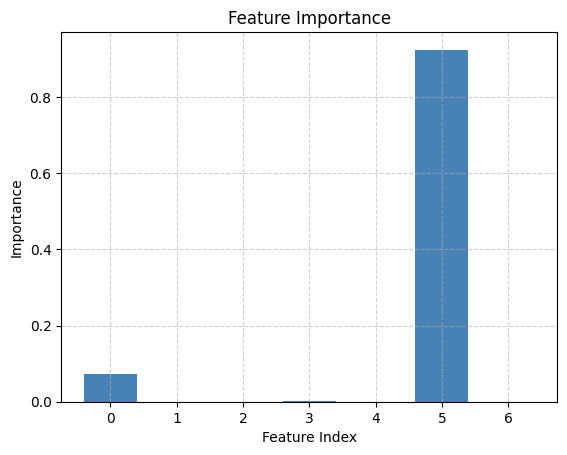

In [6]:
# Create bar plot
plt.bar(np.arange(len(forrest.featureImportance)), forrest.featureImportance, color='steelblue')

# Add labels and title
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

## Evaluating predictions

Depending on the task at hand we create a confusion matrix (classification) or simple metrics (regression). Since the number of classes is fixed to two, we don't need to change anything here.

In [7]:
if task == 'regressor':
    metrics = RegressionScores(numClasses=2)
    metrics.calcScores(prediction, validTargets, validLabels)
    print(metrics)
elif task == 'classifier':
    confusion = ConfusionMatrix(numClasses=2)
    confusion.update(prediction, validLabels)
    confusion.percentages()
    confusion.calcScores()
    print(confusion)

━━━━━━━━━━━━ evaluation ━━━━━━━━━━━━
————————— confusion matrix —————————
              Class 0     Class 1   
····································
     Class 0   15970         30     
                49%          0%     
····································
     Class 1    130        15870    
                 0%         49%     

———————————————————————————————— scores ———————————————————————————————
                accuracy       precision      sensitivity      miss rate    
·······································································
     Class 0     0.995           0.992           0.998           0.002      
     Class 1     0.995           0.998           0.992           0.008      
·······································································
       total     0.995           0.995           0.995           0.005      


## Saving and Loading a Forrest

Forrests can be converted to dictionaries and then saved as a json file. This allows us to load them and re-use them. Also json is a raw text format, which is neat.

In [8]:
ModelIO.save(forrest, 'forrest-test')
newForrest = ModelIO.load('forrest-test')
print(newForrest)

━━━━━━━━━━━━━━━ forrest ━━━━━━━━━━━━━━━
voting: Majority, booster: AdaBoosting

—————————————————————— tree: 01/15 ——————————————————————
split: CART, impurity: Entropy, leaf: Mode, nodes: 105
maxDepth: 7, reached depth: 7, minSamplesSplit: 2
·························································
╴feat: 5 <= 2.79, samples: 96000
     ├─feat: 5 <= 1.98, samples: 48527
     │   ├─feat: 0 <= 2.02, samples: 46927
     │   │   ├─feat: 5 <= 1.13, samples: 45895
     │   │   │   ├─feat: 3 <= 2.29, samples: 40851
     │   │   │   │   └─╴value: 0.0
     │   │   │   │   └─╴feat: 0 <= 1.73, samples: 449
     │   │   │   │       └─╴value: 0.0
     │   │   │   │       └─╴value: 0.0
     │   │   │   └─╴feat: 0 <= 0.85, samples: 5044
     │   │   │       ├─feat: 5 <= 1.80, samples: 4157
     │   │   │       │   └─╴value: 0.0
     │   │   │       │   └─╴value: 0.0
     │   │   │       └─╴feat: 5 <= 1.87, samples: 887
     │   │   │           └─╴value: 0.0
     │   │   │           └─╴value: 0.0
    

In [9]:
prediction = newForrest.eval(validData)

if task == 'regressor':
    newMetrics = RegressionScores(numClasses=2)
    newMetrics.calcScores(prediction, validTargets, validLabels)
    print(newMetrics)
elif task == 'classifier':
    newConfusion = ConfusionMatrix(numClasses=2)
    newConfusion.update(prediction, validLabels)
    newConfusion.percentages()
    newConfusion.calcScores()
    print(newConfusion)

━━━━━━━━━━━━ evaluation ━━━━━━━━━━━━
————————— confusion matrix —————————
              Class 0     Class 1   
····································
     Class 0   15970         30     
                49%          0%     
····································
     Class 1    130        15870    
                 0%         49%     

———————————————————————————————— scores ———————————————————————————————
                accuracy       precision      sensitivity      miss rate    
·······································································
     Class 0     0.995           0.992           0.998           0.002      
     Class 1     0.995           0.998           0.992           0.008      
·······································································
       total     0.995           0.995           0.995           0.005      


## Comment

The forrest works as well as the tree code, because it completely builds on it, thus inhereting all it's problems. The progress bar for training trees is very erratic, because it's always set to the current level and because of the recurvise learning process it's jumping between levels. Also if you are using boosting, every tree will be trained twice.